# Quiz 3 - Visão Computacional

## Felipe Bartelt de Assis Pessoa - 2016026841
***

O primeiro passo para a resolução do exercício foi criar uma função capaz de gerar uma imagem sintética. Essa função `make_pattern` recebe como argumentos o tamanho da imagem (largura, altura) `img_size`, o tamanho do quadrado (largura, altura) `block_size` e o tipo de padrão `pat_type`, cujas opções são um padrão xadrez ('chess') ou um padrão parecido com uma toalha de piquenique ('picnic'), no qual os quadrados pretos são espaçados por uma coluna inteiramente branca. Essa função simplesmente retorna a imagem que será utilizada.

A imagem retornada contém valores binários, onde $0$ indica preto e $1$ indica branco. Não foi gerada imagens utilizando uint8 por conveniência ao se adicionar ruído.

In [516]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt

def make_pattern(img_size, block_size, pat_type = 'picnic'):
    """
        img_size:   tuple(width, heigth) must be multiple of block_size
        block_size: tuple(width, heigth) 
        pat_type: 'picnic' or 'chess'
    """

    if pat_type not in ['chess', 'picnic']:
        raise ValueError(str(pat_type) + ' is not a pattern type')

    pattern = np.ones(img_size)
    corners_x = np.arange(0, img_size[0], 2*block_size[0]) 
    corners_y = np.arange(0, img_size[1], 2*block_size[1])
    
    # Completes a picnic pattern
    black_x = np.array([list(range(x, x+block_size[0])) for x in corners_x]).ravel()
    black_y = np.array([list(range(y, y+block_size[1])) for y in corners_y]).ravel()
    pattern[np.ix_(black_x, black_y)]=0

    if pat_type == 'chess':
        # add black squares into picnic pattern's white columns
        checker_x = np.array([list(range(x+block_size[0], x+2*block_size[0])) 
                              for x in corners_x[0:-1]]).ravel()
        checker_y = np.array([list(range(y+block_size[1], y+2*block_size[1])) 
                              for y in corners_y[0:-1]]).ravel()
        pattern[np.ix_(checker_x, checker_y)]=0

        corners_x = np.sort(np.append(corners_x[1::], checker_x[checker_x%block_size[0] == 0]))
        corners_y = np.sort(np.append(corners_y[1::], checker_y[checker_y%block_size[1] == 0]))
    else:
        # returns the needed corners for comparisons
        corners_x, corners_y = corners_x[1::], corners_y[1::]

    return pattern, (corners_x, corners_y)


Para adição de um ruído gaussiano à uma imagem, criou-se a função `awgn`, cujos parâmetros são a imagem `img`, a média do ruído `mean` e o desvio padrão `std`. A função retorna a imagem com ruído adicionado.

In [517]:
def awgn(img, mean, std):
    noise = np.random.default_rng().normal(mean, std, img.shape)
    noisy = (img+noise)
    
    return noisy


Em seguida, definiu-se a função para supressão de não máximo `non_max_supression`, cujos parâmetros são a matriz, ou imagem, R gerada pelo algoritmo de quinas de Harris `R` e o tamanho da janela para se computar a supressão `window_size`. Essa função adiciona um *padding* à imagem, replicando as bordas. Assim, para cada pixel da imagem original, compara-se os valores dentro da janela de tamanho `window_size`, encontra-se o valor máximo e seu respectivo índice. Todo valor não máximo é alterado para 0, assim somente o máximo continua com seu valor original. Ao final, retorna-se a matriz R modificada sem o *padding* adicionado.

In [518]:
def non_max_supression(R, window_size):
    x_size, y_size = window_size
    x_size, y_size = x_size//2, y_size//2
    padded = cv.copyMakeBorder(R, y_size, y_size ,x_size, x_size,cv.BORDER_REPLICATE)
    heigth, width = R.shape
    
    for x in range(2, width+2):
        for y in range(2, heigth+2):
            window = padded[x - x_size : x + x_size + 1, y - y_size : y + y_size + 1]
            
            if not np.sum(window):
                local_max = 0
            else:
                local_max = np.max(window)
            
            max_idx = np.unravel_index(np.argmax(window),window.shape)
            window[:] = 0
            window[max_idx] = local_max
    
    return padded[2:-2, 2:-2]


Finalmente, definiu-se a função de quinas de Harris `harris`, cujo único parâmetro é a imagem `img`. O primeiro passo do algoritmo é encontrar as derivadas da imagem, o que é feito por meio da função `cv2.Sobel`, seguindo o [tutorial da OpencV](https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html). Os valores $I_{x}^2, I_{xy}\text{ e } I_{y}^2$ são computados e os valores $S_{x}^2, S_{xy}\text{ e } S_{y}^2$ são obtidos por meio do filtro gaussiano dado pela função da OpenCV `cv2.GaussianBlur`, utilizando uma janela $5\times5$ e um desvio padrão unitário. Tanto as derivadas de $I$, quanto os valores $S$ encontrados são matrizes, cujos elementos são os resultados das operações que elas representam para cada pixel da imagem original.

O segundo passo do algoritmo é encontrar o valor $R$ para cada pixel da imagem. Uma vez que $I_{x}^2, I_{xy}, I_{y}^2, S_{x}^2, S_{xy}\text{ e } S_{y}^2$ são matrizes, pode-se encontrar uma matriz $\mathcal{R}$, com os respectivos valores $R$ para cada pixel. Para essa obtenção, utilizou-se $k=0.04$.

O terceiro passo foi unido ao quarto, devido à implementação escolhida para a supressão de não máximo. Assim, a limiarização é feita junto com essa supressão.

Por fim, o algoritmo retorna uma tupla com as coordenadas das quinas encontradas, ou seja, coordenadas da matriz $\mathcal{R}$ cujos valores não são nulos.


In [519]:
def harris(img):
    # Step 1
    grad_x = cv.Sobel(img, cv.CV_16S,1,0, ksize=3)
    grad_y = cv.Sobel(img, cv.CV_16S,0,1, ksize=3)

    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    Ix2 = abs_grad_x**2
    Iy2 = abs_grad_y**2
    Ixy = abs_grad_x * abs_grad_y

    Sx2 = cv.GaussianBlur(Ix2, (5,5), 1)
    Sy2 = cv.GaussianBlur(Iy2, (5,5), 1)
    Sxy = cv.GaussianBlur(Ixy, (5,5), 1)
    
    # Step 2
    k = 0.04
    det = (Sx2 * Sy2) - (Sxy**2)
    trace = Sx2+Sy2
    R = det - k * trace**2

    # Step 3 and 4
    supressed = non_max_supression(R, (5,5))
    corners = np.nonzero(supressed)

    return corners



O último passo tomado para o exercício foi a implementação de uma função para cálculo das métricas desejadas. A função `metrics` tem como parâmetros: as posições das quinas encontradas `found_corners` e as posições reais das quinas `original_corners`. O algoritmo percorre todas as coordenadas encontradas e compara, uma a uma, com as posições reais. Caso a as coordenadas encontradas difiram em no máximo 4 pixels, para cada coordenada $(x,y)$, então a coordenada encontrada é aceita como uma aproximação da coordenada real, nesse caso, o erro quadrático entre as coordenadas, aproximada e real, é adicionado à lista `err` e a coordenada originial adicionada à lista `found`. Essa checagem de aproximação tem um `break` para evitar que a mesma quina seja considerada aproximação de duas quinas reais.

Após todas as quinas serem comparadas, considera-se o número de quinas espúrias o número total de quinas encontradas subtraído do tamanho da lista `found`, isto é, subtrai-se do total de quinas o número de quinas reais aproximadas. O número de quinas não encontradas é tomado como o número total de quinas originais subtraído do número de coordenadas **únicas** aproximadas, ou seja, aqui se desconsidera a possível repetição de uma quina real ser aproximada por mais de uma quina prevista. Por último, computa-se o erro quadrático médio das distâncias entre coordenada aproximada e coordenada real. Uma vez que a lista `err` contém as diferenças quadráticas, basta tomar a raiz quadrada da média de `err`. Ressalta-se que o erro quadrático médio das distâncias depende da quina encontrada ser considerada uma aproximação de uma quina real, o que pode ocasionar em um erro nulo caso nenhuma quina encontrada seja próxima de uma quina real.

A função retorna então o erro quadrático médio (RMS) calculado, o número de quinas não encontradas e o número de quinas espúrias.

In [520]:
def metrics(found_corners, original_corners):
    err = np.array([0])
    found = []
    
    for t in found_corners:
        for o in original_corners:    
            if (abs(t[0]-o[0]) < 4) and (abs(t[1]-o[1]) < 4):
                err = np.append(err, np.linalg.norm(t-o)**2)
                found.append(o)
                break

    found = np.array(found)
    spurious = found_corners.shape[0] - found.shape[0]
    missed = original_corners.shape[0] - np.shape(np.unique(found, axis=0))[0]
    rms = np.sqrt(np.mean(err))

    return rms, missed, spurious


Gerou-se, pela função implementada, o seguinte padrão xadrez:

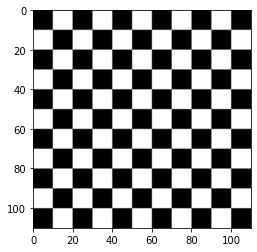

In [521]:
pat, original_corners = make_pattern((110,110),(10,10), 'chess')
plt.imshow(pat, cmap = 'gray', extent = [0,110,110,0])
plt.show()


Para o teste do algoritmo implementado, primeiro se modificou o formato das coordenadas das quinas originais `original_corners`, que era uma tupla e passou a ser uma matriz `oc` cujas linhas representam as coordenadas, ordenadas, das quinas originais.

Criou-se uma lista de desvios padrão `std_list` que comporta o desvio padrão nulo, assim como 20 pontos dentro do espaço logarítimico com intervalo $[10^{-3},10]$.

Para cada desvio padrão `std` $\in$ `std_list`, é adicionado um ruído gaussiano com média nula e desvio padrão `std` à imagem original. Sobre a imagem ruidosa, computa-se o algoritmo implementado `harris` e o algoritmo da OpenCV `cv.cornerHarris`, com janela $5$, *aperture*$=3$ e $k= 0.04$, ou seja, com os mesmos parâmetros implementados manualmente. Registra-se as quinas encontradas pelo algoritmo implementado em `corners` e as quinas encontradas pela OpenCV em `corners_cv`. A função `cv.cornerHarris` retorna uma imagem `dst`, sobre essa imagem, tomou-se como quinas as coordenadas de `dst` cujo valor fosse maior que $0.01$ vezes o valor máximo presente em `dst`.

Armazenou-se então as métricas computadas por `metrics` para cada um dos algoritmos. Também foram salvas imagens correspondentes às quinas encontradas pelo algoritmo implementado para cada desvio padrão iterado, de forma a se gerar uma animação do resultado ao final do exercício.

In [522]:
import matplotlib.animation as ani 

# reshape coordinates of original corners
oc = (np.meshgrid(np.sort(original_corners[0]), np.sort(original_corners[1])))
oc = (np.array(oc).T.reshape(-1,2)-1)

# create list of standard deviations and empty lists for metrics
std_list = np.append(0, np.logspace(-3, 1, 20))
rms_list, miss_list, spur_list = [], [], []
rms_list_cv, miss_list_cv, spur_list_cv = [], [], []

fig, ax = plt.subplots(figsize = (7,7))
ims = []

for std in std_list:
    img = awgn(pat, 0, std)
    corners = harris(img)
    norm = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    dst = cv.cornerHarris(norm, 5, 3, 0.04)
    corners_cv = np.nonzero(dst>0.01*dst.max())
    
    # compute metrics
    rms, miss, spurious = metrics(np.transpose(corners), oc)
    rms_cv, miss_cv, spurious_cv = metrics(np.transpose(corners_cv), oc)
    rms_list.append(rms)
    miss_list.append(miss)
    spur_list.append(spurious)
    rms_list_cv.append(rms_cv)
    miss_list_cv.append(miss_cv)
    spur_list_cv.append(spurious_cv)

    # save frames for animation
    color = cv.cvtColor(norm, cv.COLOR_GRAY2RGB)
    color[corners] = [255,0,0]
    im = ax.imshow(color, animated=True)
    text = ax.annotate('std = '+str(std),(0.4,0.9), xycoords= 'figure fraction')
    if std == 0:
        ax.imshow(color)
    ims.append([im, text])
    
plt.close(fig)



Feito todas as iterações, pode-se então plotar as métricas obtidas, por desvio padrão de ruído, para cada algoritmo:

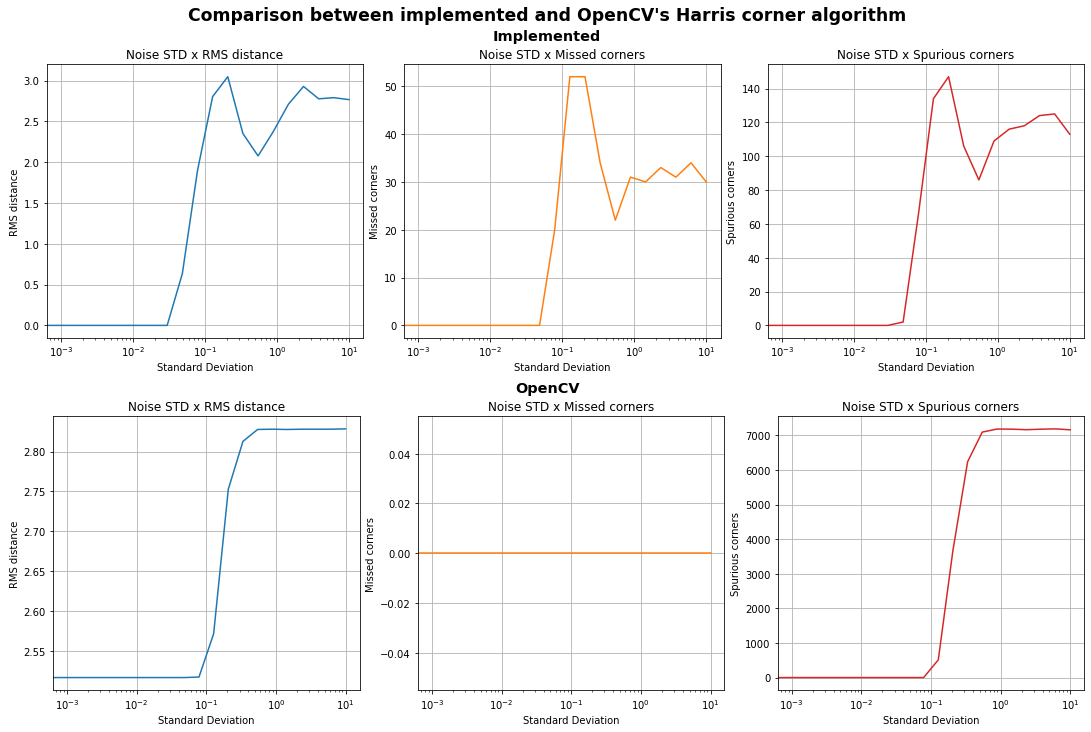

In [523]:
fig2 = plt.figure(constrained_layout=True, figsize=(15,10))
fig2.suptitle("Comparison between implemented and OpenCV's Harris corner algorithm", size = 'xx-large', weight= 'bold')

plot_list = np.array([[rms_list, miss_list, spur_list], [rms_list_cv, miss_list_cv, spur_list_cv]])
value = ['RMS distance', 'Missed corners', 'Spurious corners']
method = ['Implemented', 'OpenCV']
colors = ['tab:blue', 'tab:orange', 'tab:red']

subfigs = fig2.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(method[row], size = 'x-large', weight= 'semibold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.semilogx(std_list, plot_list[row,col], colors[col])
        ax.set(xlabel='Standard Deviation', ylabel=value[col])
        ax.set_title('Noise STD x '+value[col])
        ax.grid()


Pelos resultados acima, pode-se observar que a implementação feita foi razoável. O erro quadrático médio das distâncias entre quinas originais e quinas previstas, foi bastante próximo do obtido pelo algoritmo da OpenCV, porém com função crescente em um período anterior ao da OpenCV. Novamente, como o cálculo do RMS depende da quina prevista ser uma boa aproximação para alguma quina real, há quedas com o aumento do desvio padrão, além de uma tendência à um valor constante. Mesmo com essas ressalvas, pode-se afirmar que as posições encontradas pelo algoritmo implementado são bem próximas das encontradas pela OpenCV.

É visível a sensibilidade à ruído da implementação, uma vez que próximo a um desvio padrão $0.1$, o algoritmo passa a não encontrar $1/4$ das quinas originais, algo que não ocorre para o algoritmo da OpenCV, que nunca falha em encontrar as verdadeiras quinas. O fato do algoritmo implementado falhar menos em encontrar quinas reais para desvios padrão grandes, pode ser explicado pela probabilidade do algoritmo ter gerado uma quina em uma posição próxima de uma quina real, porém sem identificar realmente aquela posição como quina perfeitamente.

Vê-se também que o comportamento de quinas não encontradas é análogo ao de quinas espúrias, sendo quase possível de se aproximas o número de quinas espúrias como o dobro de quinas não encontradas. Para o algoritmo da OpenCV, nota-se um número muito grande de quinas espúrias próximo do desvio padrão $0.1$, isso se deve, provavelmente, pela forma como foram tomadas as quinas previstas. É possível que tomar valores $0.01$ vezes o valor máximo não seja suficiente para se separar quinas e por isso o número de quinas espúrias foi tão alto. Ressalta-se que esses valores absurdos representem praticamente a imagem inteira como quinas.

Em suma, o algoritmo implementado está longe de perfeito, porém tem um desempenho aceitável para ruídos baixos. Assim, para imagens com pouco ruído, a implementação foi um sucesso e poderia ser usada para outras aplicações, porém, para imagens ruidosas, seria muito mais viável utilizar o algoritmo intrínseco da OpenCV, buscando um tratamento melhor para localização das quinas do que o que se fez neste exercício.

Por fim, mostra-se a animação das quinas previstas para cada desvio padrão arbitrado para ruído, na qual pode-se perceber o motivo para tantos erros de posicionamento de quinas para desvios padrão altos:

In [524]:
from IPython.display import HTML

anim = ani.ArtistAnimation(fig, ims, interval=600, repeat_delay=10000)
HTML(anim.to_html5_video())


Uma vez que já havia sido implementado, resolveu-se testar a diferença de desempenho para o padrão picnic:

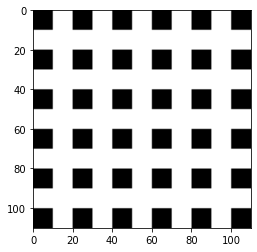

In [506]:
pat2, original_corners2 = make_pattern((110,110),(10,10), 'picnic')
plt.imshow(pat, cmap = 'gray', extent = [0,110,110,0])
plt.show()

In [525]:
# reshape coordinates of original corners
oc = (np.meshgrid(np.sort(original_corners2[0]), np.sort(original_corners2[1])))
oc = (np.array(oc).T.reshape(-1,2)-1)

# create list of standard deviations and empty lists for metrics
std_list = np.append(0, np.logspace(-3, 1, 20))
rms_list, miss_list, spur_list = [], [], []
rms_list_cv, miss_list_cv, spur_list_cv = [], [], []

fig3, ax = plt.subplots(figsize = (7,7))
ims = []

for std in std_list:
    img = awgn(pat2, 0, std)
    corners = harris(img)
    norm = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
    dst = cv.cornerHarris(norm, 5, 3, 0.04)
    corners_cv = np.nonzero(dst>0.01*dst.max())
    
    # compute metrics
    rms, miss, spurious = metrics(np.transpose(corners), oc)
    rms_cv, miss_cv, spurious_cv = metrics(np.transpose(corners_cv), oc)
    rms_list.append(rms)
    miss_list.append(miss)
    spur_list.append(spurious)
    rms_list_cv.append(rms_cv)
    miss_list_cv.append(miss_cv)
    spur_list_cv.append(spurious_cv)

    # save frames for animation
    color = cv.cvtColor(norm, cv.COLOR_GRAY2RGB)
    color[corners] = [255,0,0]
    im = ax.imshow(color, animated=True)
    text = ax.annotate('std = '+str(std),(0.4,0.9), xycoords= 'figure fraction')
    if std == 0:
        ax.imshow(color)
    ims.append([im, text])
plt.close(fig3)

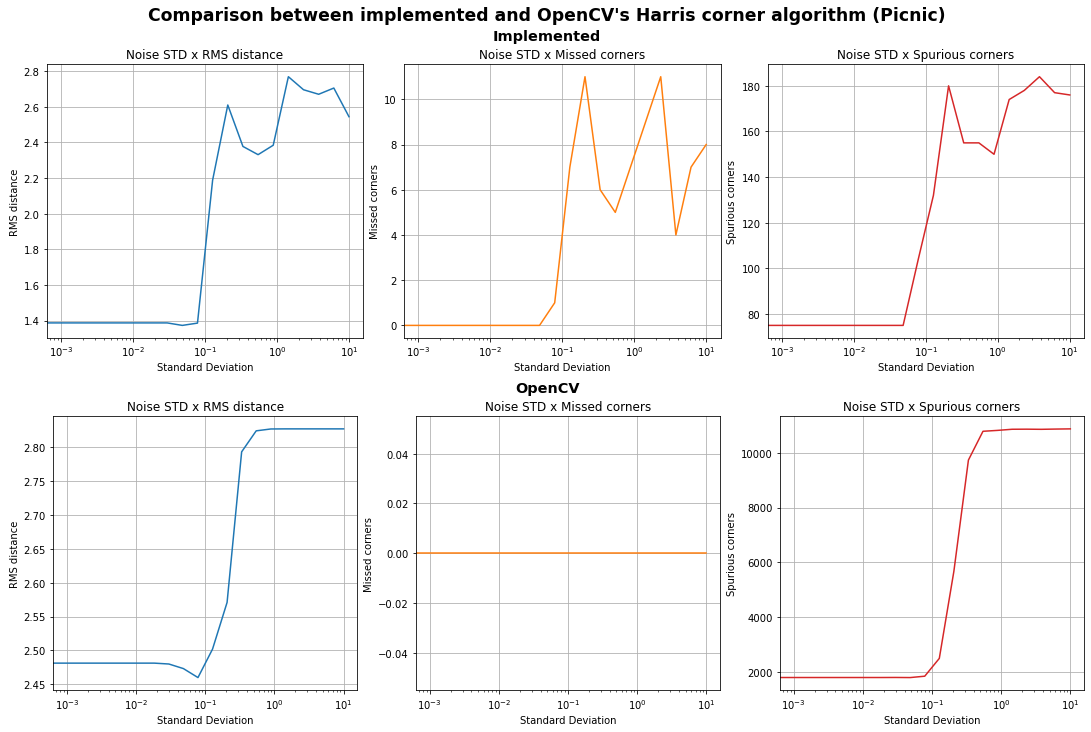

In [526]:
fig4 = plt.figure(constrained_layout=True, figsize=(15,10))
fig4.suptitle("Comparison between implemented and OpenCV's Harris corner algorithm (Picnic)", size = 'xx-large', weight= 'bold')

plot_list = np.array([[rms_list, miss_list, spur_list], [rms_list_cv, miss_list_cv, spur_list_cv]])
value = ['RMS distance', 'Missed corners', 'Spurious corners']
method = ['Implemented', 'OpenCV']
colors = ['tab:blue', 'tab:orange', 'tab:red']

subfigs = fig4.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(method[row], size = 'x-large', weight= 'semibold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        ax.semilogx(std_list, plot_list[row,col], colors[col])
        ax.set(xlabel='Standard Deviation', ylabel=value[col])
        ax.set_title('Noise STD x '+value[col])
        ax.grid()


Para esse padrão, o algoritmo implementado falhou menos vezes em encontrar quinas reais e obteve RMS menor, apesar do seu mínimo repousar em $1.4$. Mesmo com desempenho pouco melhor, o número de quinas espúrias aumentou, provavelmente devido ao ruído fazer com que colunas brancas se tornem excelente alvo para variações bruscas de intensidade. O algoritmo da OpenCV se mostrou tão bom quanto antes, porém, da mesma forma, encontrou mais quinas espúrias para esse padrão.

A animação seguinte pode explicar o fato do RMS mínimo repousar em $1.4$, assim como a existência de mais quinas espúrias:

In [527]:
anim2 = ani.ArtistAnimation(fig3, ims, interval=600, repeat_delay=10000)
HTML(anim2.to_html5_video())